# IMPORTS

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier


from sklearn.tree import plot_tree
import pylab

%matplotlib inline
pd.set_option('display.max_columns', 200)

# Load Data

In [2]:
dfTrain = pd.read_feather('../Data/FeatherData/dfTrainGS.feather')
dfTest = pd.read_feather('../Data/FeatherData/dfTestGS.feather')

In [3]:
dfTrain = dfTrain.sort_values('UploadDate')

# Generating some features to evaluate a simple model

In [4]:
dfFeatures = pd.DataFrame(index=dfTrain.index)

In [5]:
dfFeatures['ViewCount'] = dfTrain['ViewCount']
dfFeatures['DaysSincePublication'] = dfTrain['DaysSincePublication']
dfFeatures['WatchList'] = dfTrain['WatchList'].astype(int)
dfFeatures['ViewsPerDay'] = dfFeatures['ViewCount'] / dfFeatures['DaysSincePublication']
dfFeatures = dfFeatures.drop('DaysSincePublication', axis=1)

In [6]:
dfFeatures.head()

,ViewCount,WatchList,ViewsPerDay
455,3,1,0.001343
98,1,0,0.000451
372,303,1,0.137602
274,53,1,0.024190
402,9,0,0.004202


# Split DataFrame into Training and Validation Dataset

<AxesSubplot:>

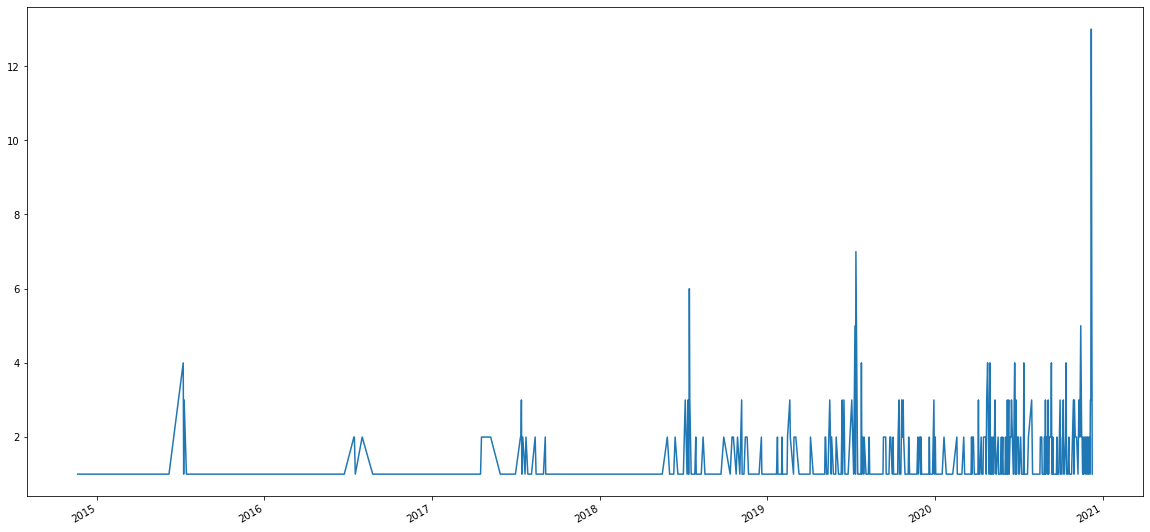

In [7]:
dfTrain['UploadDate'].value_counts().plot(figsize=(20, 10))

In [8]:
Xtrain, Xval = dfFeatures.iloc[:int(round(dfTrain.shape[0]/2,0))].drop('WatchList', axis=1), dfFeatures.iloc[int(round(dfTrain.shape[0]/2,0)):].drop('WatchList', axis=1)
ytrain, yval = dfFeatures['WatchList'].iloc[:int(round(dfTrain.shape[0]/2,0))], dfFeatures['WatchList'].iloc[int(round(dfTrain.shape[0]/2,0)):]

In [9]:
Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((400, 2), (400, 2), (400,), (400,))

# Text Features

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

titleTrain = dfTrain['Title'].iloc[:int(round(dfTrain.shape[0]/2,0))]
titleVal = dfTrain['Title'].iloc[int(round(dfTrain.shape[0]/2,0)):]

titleVec = TfidfVectorizer(min_df=2)
titleBowTrain = titleVec.fit_transform(titleTrain)
titleBowVal = titleVec.transform(titleVal)

In [21]:
titleBowTrain.shape

(400, 339)

In [22]:
titleBowTrain

<400x339 sparse matrix of type '<class 'numpy.float64'>'
	with 2913 stored elements in Compressed Sparse Row format>

In [23]:
from scipy.sparse import hstack

XtrainWTitle = hstack([Xtrain, titleBowTrain])
XvalWTitle = hstack([Xval, titleBowVal])

In [24]:
XtrainWTitle.shape, XvalWTitle.shape

((400, 341), (400, 341))

# Model

## DecisionTreeClassifier

In [26]:
model = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight='balanced', n_jobs=-1)
model.fit(XtrainWTitle, ytrain)

RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=-1,
                       random_state=0)

In [29]:
p = model.predict_proba(XvalWTitle)[:,1]

## Model Evaluate 

In [30]:
average_precision_score(yval,p)

0.4544472138690866

In [31]:
roc_auc_score(yval, p)

0.7480390838599793